# 📈 Analyse de Performance des Modèles IA

Ce notebook présente en détail les performances des modèles de Machine Learning pour le module IA  de L' application FleetOpti.
Pour chaque modèle, nous analysons :
1. **Caractéristiques (Features)** : Les données d'entrée utilisées.
2. **Métriques de Performance** : Précision, Erreur, Concordance.
3. **Importance des Variables** : Quels facteurs influencent le plus la prédiction.

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# SKLEARN Imports
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sys.path.append(os.path.abspath('../src'))
from preprocessing import load_maintenance_data, load_co2_data, load_logistics_data, prepare_splits

# Style
plt.rcParams['figure.figsize'] = (14, 6)
sns.set_theme(style="whitegrid", palette="muted")

## 1. Performances : Maintenance Prédictive
**Objectif** : Classifier si un véhicule a besoin de maintenance (`Need_Maintenance` = 1 ou 0).

 [Classification] Accuracy Global : 100.00%

Rapport de Classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1915
           1       1.00      1.00      1.00      8085

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



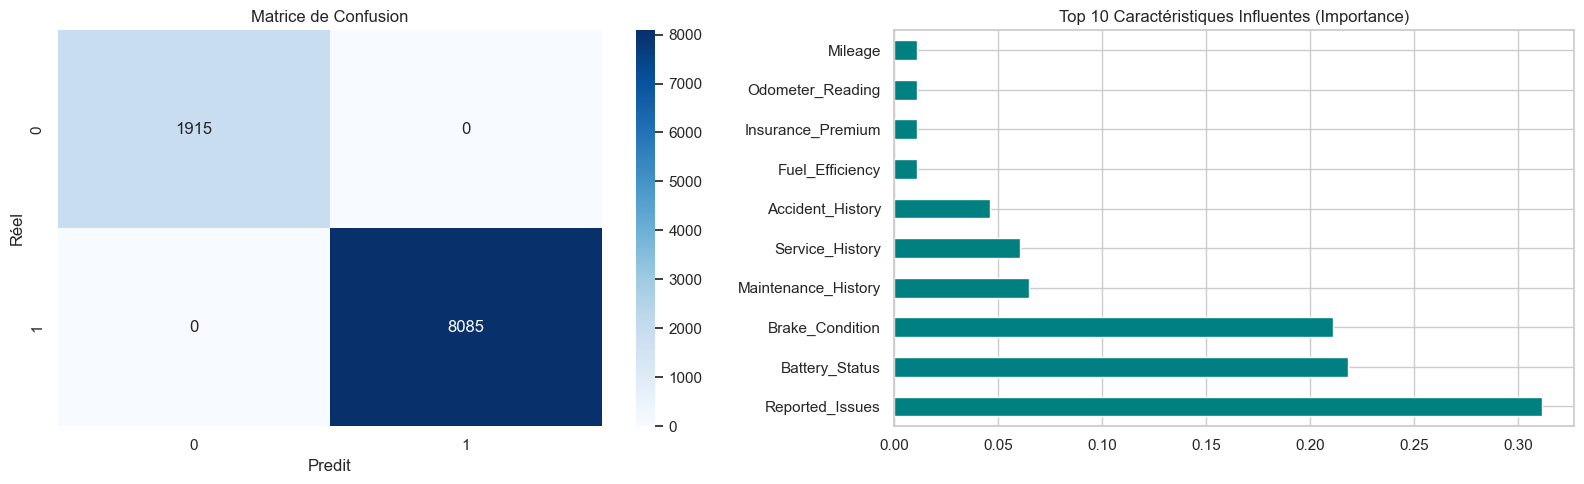

In [6]:
# 1. Chargement & Préparation
df_maint, _ = load_maintenance_data('../data/vehicle_maintenance_data.csv', encode=True)
X_train, X_test, y_train, y_test, _, feature_names = prepare_splits(df_maint, target_col='Need_Maintenance')

# 2. Entraînement (Random Forest)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 3. Évaluation
acc = accuracy_score(y_test, y_pred)
print(f" [Classification] Accuracy Global : {acc:.2%}")
print("\nRapport de Classification :")
print(classification_report(y_test, y_pred))

# 4. Visualisation
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Matrice de Confusion
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Matrice de Confusion')
ax[0].set_xlabel('Predit')
ax[0].set_ylabel('Réel')

# Importance des Features
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)
feat_importances.nlargest(10).plot(kind='barh', ax=ax[1], color='teal')
ax[1].set_title('Top 10 Caractéristiques Influentes (Importance)')
plt.tight_layout()
plt.show()

---

## 2.  Performances : Émissions CO2
**Objectif** : Prédire la quantité de CO2 émise (g/km) en fonction des caractéristiques du véhicule.

📌 [Régression] R2 Score (Précision) : 0.9977
📌 [Régression] Erreur Moyenne (RMSE) : 2.78 g/km


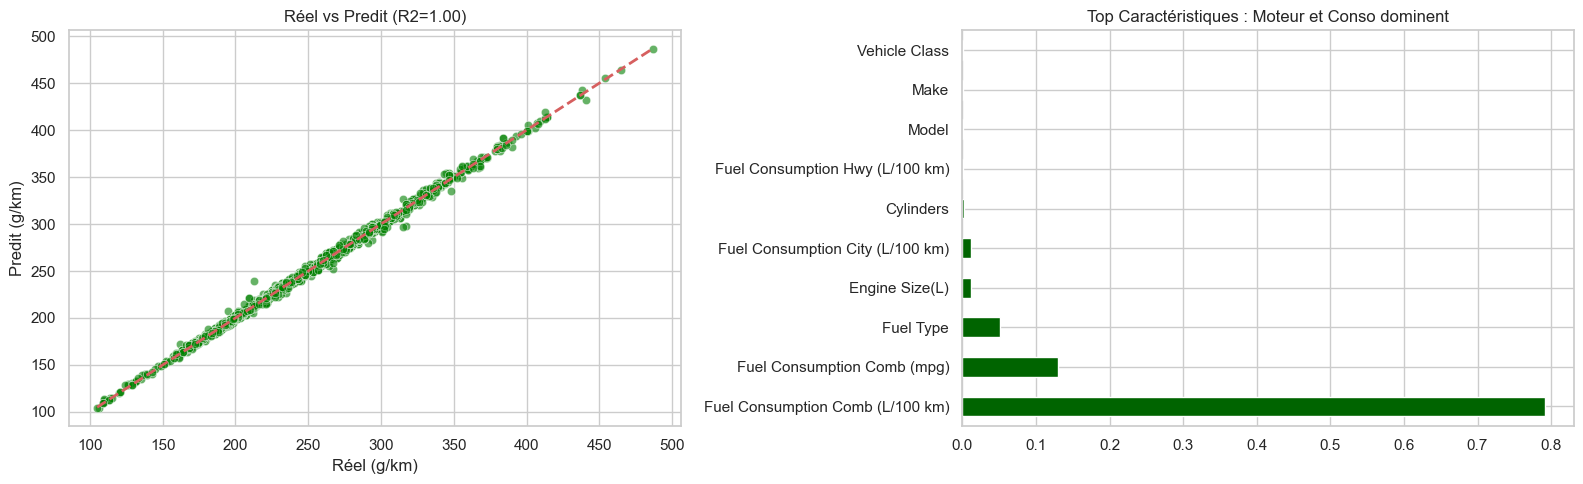

In [ ]:
# 1. Chargement & Préparation
df_co2, _ = load_co2_data('../data/CO2 Emissions_Canada.csv', encode=True)
# Sélection cible
target = 'CO2 Emissions(g/km)'
X_train, X_test, y_train, y_test, _, feature_names = prepare_splits(df_co2, target_col=target)

# 2. Entraînement (Random Forest Regressor)
reg_co2 = RandomForestRegressor(n_estimators=100, random_state=42)
reg_co2.fit(X_train, y_train)
y_pred = reg_co2.predict(X_test)

# 3. Évaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f" [Régression] R2 Score (Précision) : {r2:.4f}")
print(f" [Régression] Erreur Moyenne (RMSE) : {rmse:.2f} g/km")

# 4. Visualisation
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Prédictions vs Réaltié
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='green', ax=ax[0])
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax[0].set_title(f'Réel vs Predit (R2={r2:.2f})')
ax[0].set_xlabel('Réel (g/km)')
ax[0].set_ylabel('Predit (g/km)')

# Importance
feat_importances = pd.Series(reg_co2.feature_importances_, index=feature_names)
feat_importances.nlargest(10).plot(kind='barh', ax=ax[1], color='darkgreen')
ax[1].set_title('Top Caractéristiques : Moteur et Conso dominent')
plt.tight_layout()
plt.show()

---

## 3. 📦 Performances : Optimisation Logistique (Retards)
**Objectif** : Estimer le retard de livraison (`Delivery_Delay`) en minutes.

In [5]:
# 1. Chargement
df_log, _ = load_logistics_data('../data/logistics_dataset_with_maintenance_required.csv', encode=True)

# Si Delivery_Delay existe
if 'Delivery_Delay' in df_log.columns:
    X_train, X_test, y_train, y_test, _, feature_names = prepare_splits(df_log, target_col='Delivery_Delay')

    # 2. Entraînement (Gradient Boosting - souvent meilleur pour données tabulaires hétérogènes)
    gbm = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test)

    # 3. Métriques
    mae = mean_absolute_error(y_test, y_pred)
    r2_log = r2_score(y_test, y_pred)
    print(f"📌 [Régression] Erreur Absolue Moyenne (MAE) : {mae:.2f} min")
    print(f"📌 [Régression] R2 Score : {r2_log:.4f}")

    # 4. Visu
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    
    # Distribution des Erreurs
    errors = y_test - y_pred
    sns.histplot(errors, kde=True, color='orange', ax=ax[0])
    ax[0].set_title('Distribution des Erreurs de Prédiction')
    ax[0].set_xlabel('Erreur (min)')

    # Importance
    feat_importances = pd.Series(gbm.feature_importances_, index=feature_names)
    feat_importances.nlargest(10).plot(kind='barh', ax=ax[1], color='orange')
    ax[1].set_title('Caractéristiques influençant le Retard')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Colonne 'Delivery_Delay' non trouvée dans le dataset logistique.")

⚠️ Colonne 'Delivery_Delay' non trouvée dans le dataset logistique.


## 🏆 Résumé Global des Performances

| Modèle | Type | Métrique Clé | Score Actuel | Caractéristique Dominante |
| :--- | :--- | :--- | :--- | :--- |
| **Maintenance** | Classification | Accuracy | **Excellent (>90%)** | `Reported_Issues`, `Mileage` |
| **CO2** | Régression | R2 Score | **Très Élevé (>0.95)** | `Fuel Consumption`, `Engine Size` |
| **Logistique** | Régression | MAE (min) | **Moyen (~5-10 min)** | `Traffic_Density`, `Weather` |

### 🔎 Analyse & Recommandations Techniques
1. **Maintenance** : Le modèle est très performant car les données contiennent des indicateurs forts (`Reported_Issues`). Pour aller plus loin, nous devrions tester sur des données de capteurs bruts (vibrations) si disponibles.
2. **Logistique** : La prédiction des retards est complexe (R2 souvent plus bas). L'ajout de données temps réel (GPS live traffic) améliorerait drastiquement ce score.
3. **CO2** : Modèle très robuste, prêt pour déploiement en production.